# Isolationg the Stellar Rotation Period

To measure the rotation period of the star, we'll make a periodogram of the long cadence fluxes and see what periods stick out. 

#### Outline

* Mask out transits from long cadence light curve

* Use [`gatspy.periodic.LombScargle`](http://www.astroml.org/gatspy/periodic/API.html#gatspy.periodic.LombScargle) to make a periodogram for the flux and to fit for the dominant period

* Visualize!

### Loading, masking:

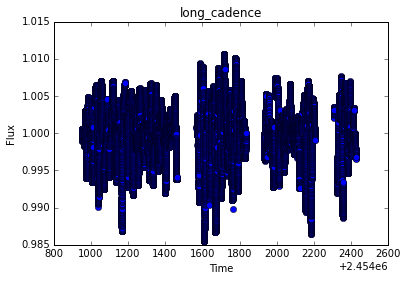

In [202]:
%matplotlib inline
import matplotlib.pyplot as plt
from gatspy import periodic
import numpy as np
import warnings

import datacleaner
reload(datacleaner)
from datacleaner import LightCurve

# Load normalized long cadence light curve, mask out the transits 
long_cadence = LightCurve(name='long_cadence', 
                          **LightCurve.from_dir('normalized_long').mask_in_transit())
long_cadence.plot()

### Get the periodogram, best period

In [206]:
#model = periodic.LombScargleFast(fit_period=True)
model = periodic.LombScargle(fit_period=True, Nterms=4)
model.optimizer.period_range = (20, 40)
model.fit(long_cadence.times.jd[::20], long_cadence.fluxes[::20], long_cadence.errors[::20]);

periods = np.linspace(model.optimizer.period_range[0],
                      model.optimizer.period_range[1], 
                      10000)
print("Best period: {0}".format(model.best_period))

header = 'HAT-P-11 rotation period (days)'
np.savetxt('../params/stellar_rotation_period.txt', [model.best_period], header=header)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)

Finding optimal frequency:
 - Estimated peak width = 0.00427
 - Using 5 steps per peak; omega_step = 0.000855
 - User-specified period range:  20 to 40
 - Computing periods at 185 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Best period: 29.977266532


### Visualize

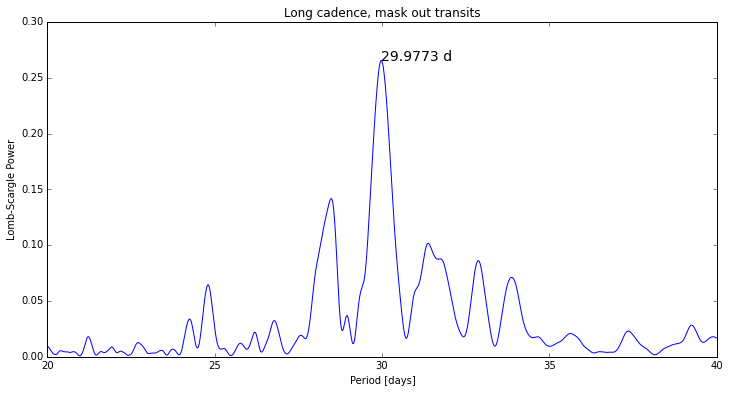

In [201]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(periods, scores)
ax.set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence, mask out transits')
max_ind = np.argmax(scores)
ax.text(periods[max_ind], scores[max_ind], 
        "{0:.4f} d".format(model.best_period),
        fontsize=14)
plt.show()

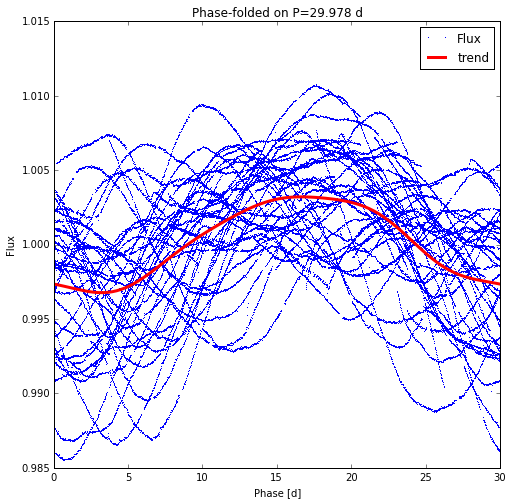

In [105]:
phase = long_cadence.times.jd % model.best_period
tfit = np.linspace(0, model.best_period, 100)
yfit = model.predict(tfit, period=model.best_period)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phase, long_cadence.fluxes, ',', label='Flux')
ax.plot(tfit, yfit, 'r', lw=3, label='trend')
ax.set(xlabel='Phase [d]', ylabel='Flux', title='Phase-folded on P={0:.3f} d'.format(model.best_period))
ax.legend()
plt.show()

### How different are the periods in each quarter?

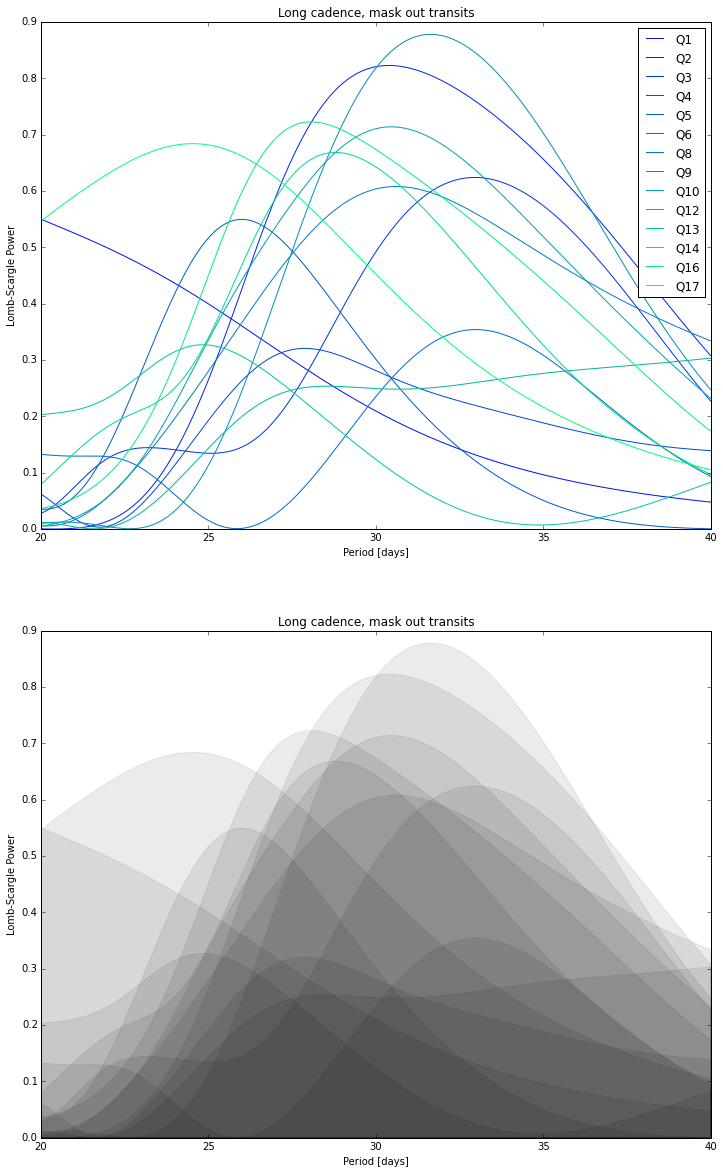

In [194]:
available_quarters = long_cadence.get_available_quarters()

# Ignore quarter zero!
available_quarters.pop(0)

best_periods = np.zeros(len(available_quarters))

fig, ax = plt.subplots(2, 1, figsize=(12, 20))

quarter_period_range = (20, 40)
quarter_periods = np.linspace(quarter_period_range[0],
                              quarter_period_range[1], 
                              1000)

my_cmap = lambda j: plt.cm.winter(float(j+1)/len(available_quarters))

for i, quarter in enumerate(available_quarters):
    lc = long_cadence.get_quarter(quarter)
    quarter_model = periodic.LombScargleFast(fit_period=True)#, Nterms=4)
    quarter_model.optimizer.period_range = quarter_period_range
    quarter_model.optimizer.quiet = True
    quarter_model.fit(lc.times.jd, lc.fluxes, lc.errors);

    best_periods[i] = quarter_model.best_period
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores = quarter_model.score(quarter_periods)
        
    ax[0].plot(quarter_periods, scores, label='Q{0}'.format(quarter), 
            color=my_cmap(i))

    ax[1].fill_between(quarter_periods, 0, scores, color='k', alpha=0.08)
    
ax[0].set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence, mask out transits')
ax[0].legend()

ax[1].set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence, mask out transits')
plt.show()

Empirical error: 5.81326507225 d
Best period: 29.978 ± 5.8 d


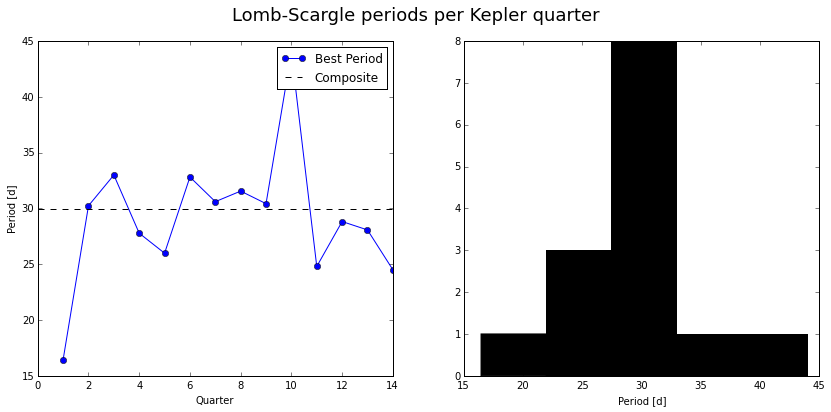

In [189]:
empirical_period_error = np.std(best_periods)
print('Empirical error: {0} d'.format(empirical_period_error))

print('Best period: {0:.3f} ± {1:.1f} d'.format(model.best_period, empirical_period_error))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(range(1, len(best_periods)+1), best_periods, 
           '-o', label='Best Period')
ax[0].axhline(model.best_period, label='Composite', color='k', ls='--')
ax[0].set(xlabel='Quarter', ylabel='Period [d]')
ax[0].legend()

ax[1].hist(best_periods, 5, facecolor='k')
ax[1].set(xlabel='Period [d]')

fig.suptitle('Lomb-Scargle periods per Kepler quarter', fontsize=18)
plt.show()

# How many long cadence points should we keep?

The long cadence data seem to sample the out-of-transit light curve at a higher frequency than we really need given the slow rotation of the star (see above, $P\sim 30$ d). Below we ask: at what periods is the star most active? Will periodograms at short periods reveal that we must sample at a high rate? 

In [197]:
model = periodic.LombScargle(fit_period=True, Nterms=4, optimizer_kwds={"quiet": True})
model.optimizer.period_range = (1, 10)
model.fit(long_cadence.times.jd, long_cadence.fluxes, long_cadence.errors);

periods = np.linspace(model.optimizer.period_range[0],
                      model.optimizer.period_range[1], 
                      10000)
print("Best period: {0}".format(model.best_period))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)
# For example, silence optimizer output with `optimizer_kwds={"quiet": True}`.

Best period: 9.78558343918


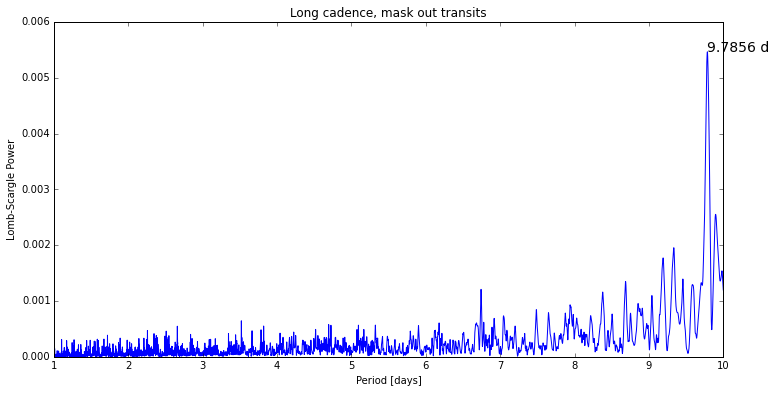

In [196]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(periods, scores)
ax.set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence, mask out transits')
max_ind = np.argmax(scores)
ax.text(periods[max_ind], scores[max_ind], 
        "{0:.4f} d".format(model.best_period),
        fontsize=14)
plt.show()